In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,FastICA,TruncatedSVD
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE

In [15]:
hp={
    "cov_thresh":0.8,
    # "iters": range(1,20,1), # iterations for sgd reg
    'ex_var' : 0.7, # explained variace
}

# step 1 - loading data

In [16]:
df = pd.read_csv('BostonHousing.csv')

print(df.head())

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       501 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [18]:
null_counts = df.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print("columns with null values:", columns_with_nulls)

columns with null values: rm    5
dtype: int64


rm is a continious feature , we can replace null with mean

In [19]:
df= df.fillna(df.mean())

no null data , no categorical data that require one hot encoding too

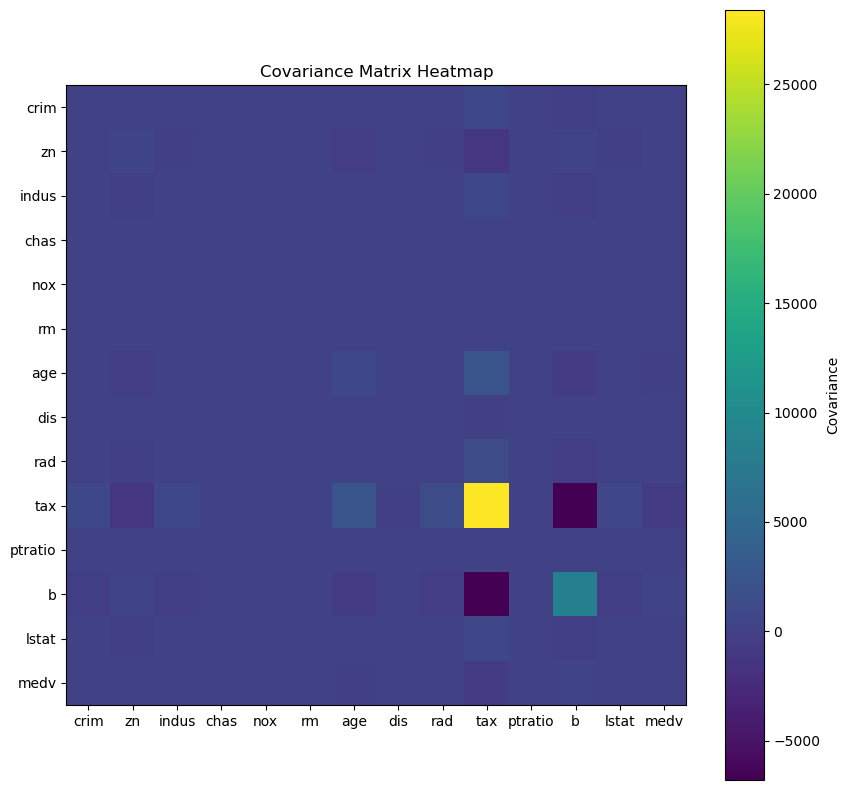

In [20]:
cov_matrix = df.cov()

plt.figure(figsize=(10, 10))
plt.imshow(cov_matrix)
plt.colorbar(label='Covariance')
plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns)
plt.yticks(range(len(cov_matrix.index)), cov_matrix.index)
plt.title('Covariance Matrix Heatmap')
plt.show()

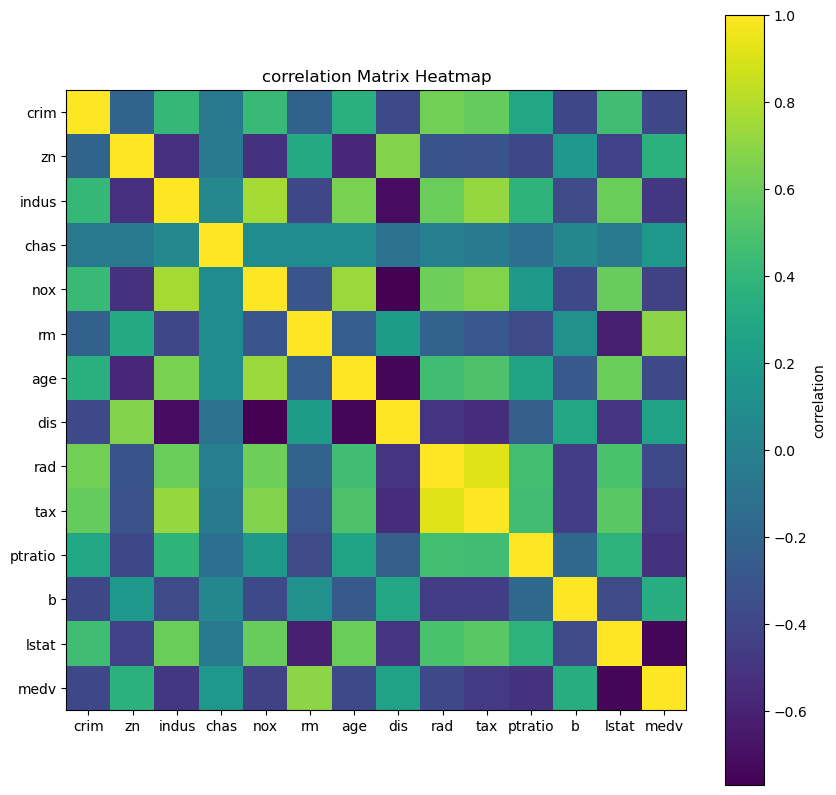

In [21]:
corr_matrix = df.corr() # pandas automaticly standardize

plt.figure(figsize=(10, 10))
plt.imshow(corr_matrix)
plt.colorbar(label='correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title('correlation Matrix Heatmap')
plt.show()

In [22]:
print(f"Feature with strong correlation (> {hp["cov_thresh"]} or < {-hp["cov_thresh"]}):\n")
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # avoid duplicates and self correlation (upper triangle)
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > hp["cov_thresh"]:
            print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {corr_value}")

Feature with strong correlation (> 0.8 or < -0.8):

rad - tax: 0.9102281885331865


In [23]:
X = df.iloc[:, :-1]   # all columns except last
y = df.iloc[:, -1]    # only last column


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, # dataset is small so i use 0.8       
    random_state=42,     
    shuffle=True         
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (404, 13)
X_test shape: (102, 13)


# train on normal model

In [24]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train, y_train)

print("Iterations:", sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train, y_train))
print("Test Score:", sgd_reg.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test)))

Iterations: 57
Coefficients: [-7.97862843e+10 -1.36972878e+11 -2.46900226e+11 -3.81222649e+10
  6.67726622e+09 -1.40805136e+11  6.14540531e+11 -2.08068042e+11
 -1.93706063e+11  3.74465949e+11 -5.70468768e+10 -2.25981271e+11
  4.04108209e+11]
Intercept: [1.13183431e+10]
Train Score: -2.162228724896287e+26
Test Score: -2.9523271266846455e+26
MSE: 2.165053173266311e+28


In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

we want a fare comparision so we standardize for all models

Coefficients: [-1.13050524e-01  3.02091590e-02  4.17263876e-02  2.78758593e+00
 -1.71889290e+01  4.42919339e+00 -6.10912587e-03 -1.44214134e+00
  2.62752943e-01 -1.06465658e-02 -9.18081330e-01  1.23491646e-02
 -5.08973486e-01]
Intercept: 30.296362371790956
Train Score: 0.7503680174420174
Test Score: 0.6672089705941917
MSE: 24.40482518814621


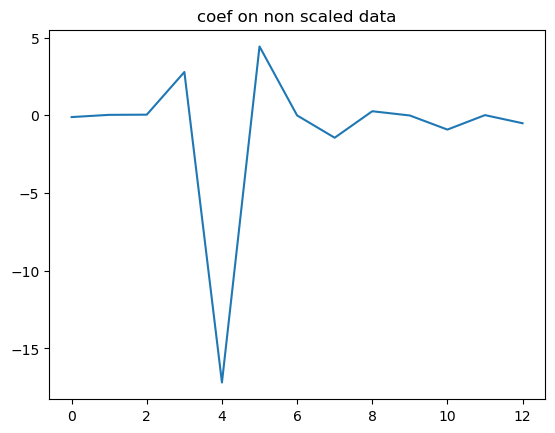

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train, y_train))
print("Test Score:", lin_reg.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test)))
plt.plot(lin_reg.coef_)
plt.title("coef on non scaled data")
plt.show()

Coefficients: [-1.00208747  0.69855082  0.28733122  0.71955092 -2.02070833  3.13708935
 -0.17081271 -3.06972351  2.25417948 -1.76697719 -2.04359481  1.12936985
 -3.61451369]
Intercept: 22.796534653465343
Train Score: 0.7503680174420175
Test Score: 0.6672089705941878
MSE: 24.40482518814649


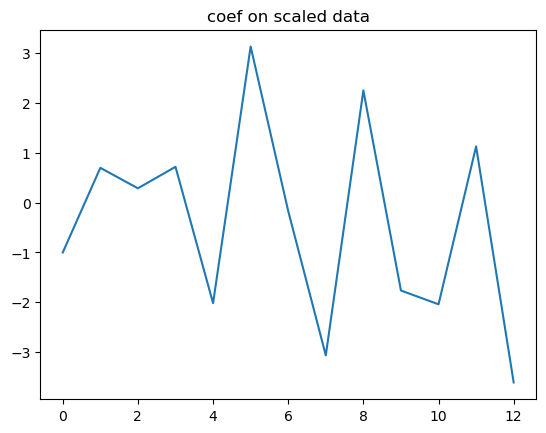

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_scaled, y_train))
print("Test Score:", lin_reg.score(X_test_scaled, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_scaled)))
plt.plot(lin_reg.coef_)
plt.title("coef on scaled data")
plt.show()

In [28]:
# losses_main_data = []
# for iters in hp["iters"]:
#     sgd_reg = SGDRegressor(max_iter=iters, tol=None, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
#     sgd_reg.fit(X_train_scaled, y_train)
#     # print("Coefficients:", sgd_reg.coef_)
#     # print("Intercept:", sgd_reg.intercept_)
#     # print("Train Score:", sgd_reg.score(X_train_scaled, y_train))
#     # print("Test Score:", sgd_reg.score(X_test_scaled, y_test))
#     losses_main_data.append( mean_squared_error(y_test,sgd_reg.predict(X_test_scaled)))
#     print(f"max iteration is {iters} MSE: {losses_main_data[-1]}")

# plt.plot(losses_main_data)
# plt.title("losses on scaled data")
# plt.xlabel("iteration")
# plt.ylabel("loss")
# plt.show()

In [29]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_scaled, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_scaled, y_train))
print("Test Score:", sgd_reg.score(X_test_scaled, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_scaled)))

Number of iteration to convergence 33
Coefficients: [-0.93961794  0.5543956   0.06359074  0.7938204  -1.87058975  3.22198316
 -0.17816502 -2.93026732  1.56761838 -1.03936594 -2.00133297  1.1228693
 -3.6028164 ]
Intercept: [22.79557386]
Train Score: 0.7494736648309264
Test Score: 0.6590919580669077
MSE: 25.00007642473168


# pca

In [30]:
pca = PCA(n_components=hp["ex_var"],random_state=42)  # Choose enough components to explain 50% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("number of components selected:", pca.n_components_)
print("explained variance ratio of selected components:", pca.explained_variance_ratio_)
print("total explained variance:", sum(pca.explained_variance_ratio_))

number of components selected: 4
explained variance ratio of selected components: [0.46371757 0.11402956 0.09767439 0.06702058]
total explained variance: 0.7424421089076724


Coefficients: [-2.26675911  2.73866442  3.30660822  0.34774544]
Intercept: 22.796534653465343
Train Score: 0.6455554401609156
Test Score: 0.5949700896222317
MSE: 29.7023756210883


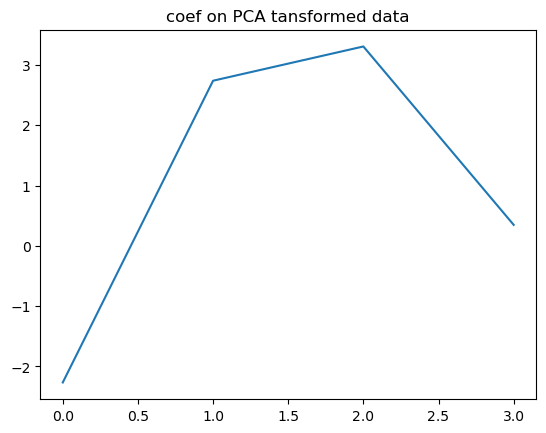

In [31]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_pca, y_train))
print("Test Score:", lin_reg.score(X_test_pca, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_pca)))
plt.plot(lin_reg.coef_)
plt.title("coef on PCA tansformed data")
plt.show()


In [32]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_pca, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_pca, y_train))
print("Test Score:", sgd_reg.score(X_test_pca, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_pca)))

Number of iteration to convergence 30
Coefficients: [-2.27470102  2.78436367  3.31880976  0.32760358]
Intercept: [22.79662172]
Train Score: 0.645509182166169
Test Score: 0.5933068372345578
MSE: 29.824348211026873


# SVD

In [33]:
for i in range(1,X_train.shape[1]+1,1):
    svd = TruncatedSVD(n_components=i,random_state=42)
    svd.fit(X_train_scaled)
    if(sum(svd.explained_variance_ratio_)>=hp["ex_var"]):
        break

X_train_svd = svd.transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)
print("number of components selected:", i)
print("explained variance ratio of selected components:", svd.explained_variance_ratio_)
print("total explained variance:", sum(svd.explained_variance_ratio_))

number of components selected: 4
explained variance ratio of selected components: [0.46371757 0.11402956 0.09767439 0.06702058]
total explained variance: 0.7424421089076723


Coefficients: [-2.26675911  2.73866442  3.30660822  0.34774544]
Intercept: 22.796534653465343
Train Score: 0.6455554401609152
Test Score: 0.5949700896222325
MSE: 29.70237562108824


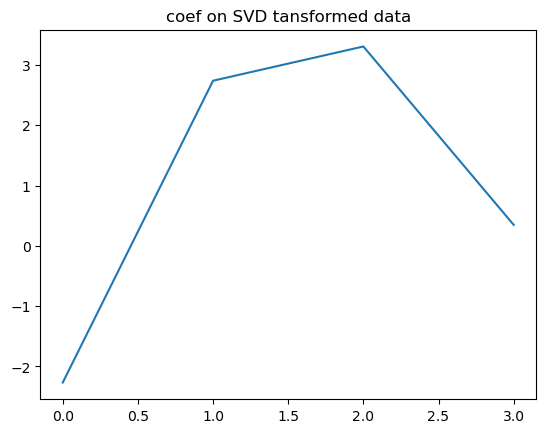

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_svd, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_svd, y_train))
print("Test Score:", lin_reg.score(X_test_svd, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_svd)))
plt.plot(lin_reg.coef_)
plt.title("coef on SVD tansformed data")
plt.show()

In [35]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_svd, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_svd, y_train))
print("Test Score:", sgd_reg.score(X_test_svd, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_svd)))

Number of iteration to convergence 30
Coefficients: [-2.27470102  2.78436367  3.31880976  0.32760358]
Intercept: [22.79662172]
Train Score: 0.6455091821661685
Test Score: 0.5933068372345587
MSE: 29.82434821102681


# ICA

In [36]:
ica = FastICA(n_components=int(X_train.shape[1]/2),random_state=42)  # choose n comp as half of the features
X_train_ica = ica.fit_transform(X_train_scaled)
X_test_ica = ica.transform(X_test_scaled)

print("number of components selected:", int(X_train.shape[1]/2))

number of components selected: 6


Coefficients: [ 0.24622836  2.75347814 -2.20827571 -2.70886921  1.69913186  6.27039887]
Intercept: 22.796534653465343
Train Score: 0.7143921213596283
Test Score: 0.595375673516771
MSE: 29.672632619712832


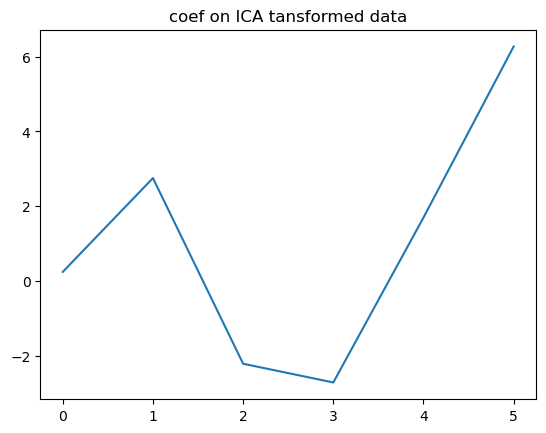

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_ica, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_ica, y_train))
print("Test Score:", lin_reg.score(X_test_ica, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_ica)))
plt.plot(lin_reg.coef_)
plt.title("coef on ICA tansformed data")
plt.show()

In [38]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_ica, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_ica, y_train))
print("Test Score:", sgd_reg.score(X_test_ica, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_ica)))

Number of iteration to convergence 39
Coefficients: [ 0.24112106  2.74764    -2.21525614 -2.70445464  1.72234185  6.26487016]
Intercept: [22.81497786]
Train Score: 0.7143801751748472
Test Score: 0.5955845543130296
MSE: 29.657314600693656


number of components selected: 6
Coefficients: [-3.80832537 -6.09945025  0.64790524 -1.98876388]
Intercept: 22.796534653465343
Train Score: 0.6455554401609145
Test Score: 0.594970089622235
MSE: 29.70237562108806


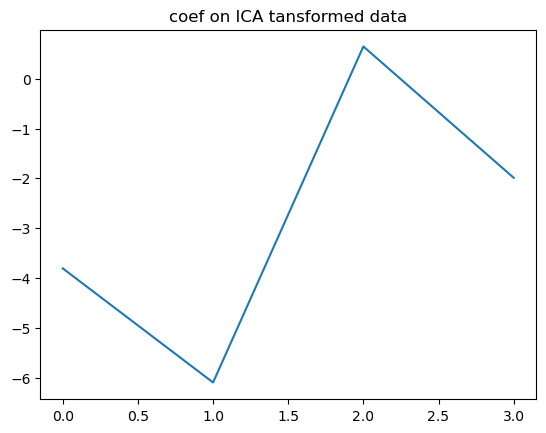

In [50]:
ica = FastICA(n_components=4,random_state=42,max_iter=10000)  # choose n comp as half of the features
X_train_ica = ica.fit_transform(X_train_scaled)
X_test_ica = ica.transform(X_test_scaled)

print("number of components selected:", int(X_train.shape[1]/2))
lin_reg = LinearRegression()
lin_reg.fit(X_train_ica, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_ica, y_train))
print("Test Score:", lin_reg.score(X_test_ica, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_ica)))
plt.plot(lin_reg.coef_)
plt.title("coef on ICA tansformed data")
plt.show()

# select K best using F test

In [40]:
col_names = df.columns[:-1].to_numpy()
print(col_names)

['crim' 'zn' 'indus' 'chas' 'nox' 'rm' 'age' 'dis' 'rad' 'tax' 'ptratio'
 'b' 'lstat']


In [41]:
selector = SelectKBest(score_func=f_regression, k=int(X_train.shape[1]/2))
X_train_ftest = selector.fit_transform(X_train_scaled, y_train)
X_test_ftest = selector.transform(X_test_scaled)
print(f"selected features : {col_names[selector.get_support()]}")

selected features : ['indus' 'nox' 'rm' 'tax' 'ptratio' 'lstat']


Coefficients: [ 0.84740048 -0.34844535  3.63993237 -0.75249832 -1.84303748 -3.87099116]
Intercept: 22.796534653465343
Train Score: 0.6904341512235597
Test Score: 0.6206052474422608
MSE: 27.822452516233636


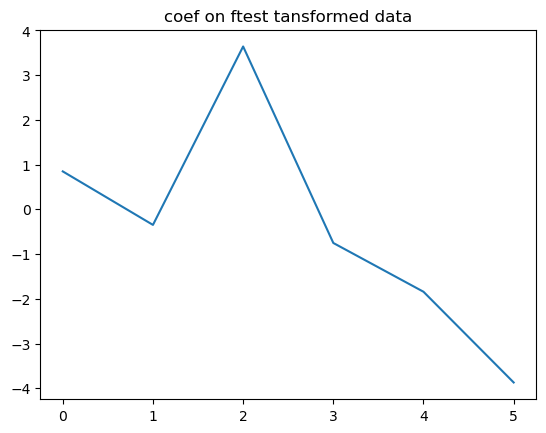

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_ftest, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_ftest, y_train))
print("Test Score:", lin_reg.score(X_test_ftest, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_ftest)))
plt.plot(lin_reg.coef_)
plt.title("coef on ftest tansformed data")
plt.show()

In [43]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_ftest, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_ftest, y_train))
print("Test Score:", sgd_reg.score(X_test_ftest, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_ftest)))

Number of iteration to convergence 16
Coefficients: [ 0.70919361 -0.2743554   3.67168835 -0.75973415 -1.85304701 -3.84772733]
Intercept: [22.7975218]
Train Score: 0.6903033864566689
Test Score: 0.6202684051647285
MSE: 27.84715443477341


# select K best using mutual info

In [44]:
selector = SelectKBest(score_func=mutual_info_regression, k=int(X_train.shape[1]/2))
X_train_mut = selector.fit_transform(X_train_scaled, y_train)
X_test_mut = selector.transform(X_test_scaled)
print(f"selected features : {col_names[selector.get_support()]}")

selected features : ['crim' 'indus' 'nox' 'rm' 'ptratio' 'lstat']


Coefficients: [-0.79670907  0.65343511 -0.43492924  3.6423     -1.9101585  -3.74626674]
Intercept: 22.796534653465343
Train Score: 0.693315685611187
Test Score: 0.6141795018157777
MSE: 28.29367675264953


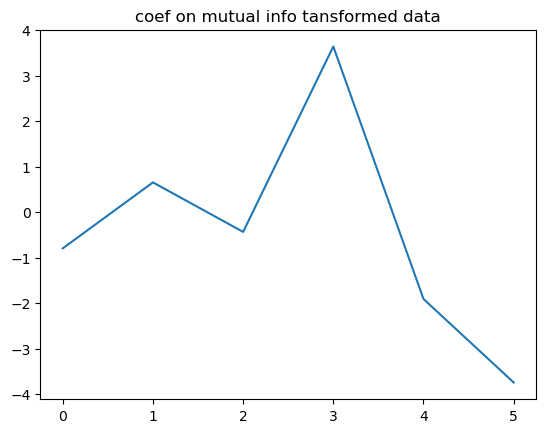

In [45]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_mut, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_mut, y_train))
print("Test Score:", lin_reg.score(X_test_mut, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_mut)))
plt.plot(lin_reg.coef_)
plt.title("coef on mutual info tansformed data")
plt.show()

In [46]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_mut, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_mut, y_train))
print("Test Score:", sgd_reg.score(X_test_mut, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_mut)))

Number of iteration to convergence 24
Coefficients: [-0.80426597  0.57642003 -0.41827933  3.64205953 -1.9133607  -3.73392819]
Intercept: [22.80290122]
Train Score: 0.6932695581394255
Test Score: 0.6148131662844403
MSE: 28.247207739908234


# RFE (interaction between features affected too)

In [47]:
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=int(X_train.shape[1]/2))

X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)
print(f"selected features : {col_names[rfe.support_]}")

selected features : ['nox' 'rm' 'dis' 'tax' 'ptratio' 'lstat']


Coefficients: [-1.85990595  3.24892028 -2.57491078 -0.42745453 -2.07252829 -4.06609282]
Intercept: 22.796534653465343
Train Score: 0.7173419269256986
Test Score: 0.6497747011968247
MSE: 25.68334611969137


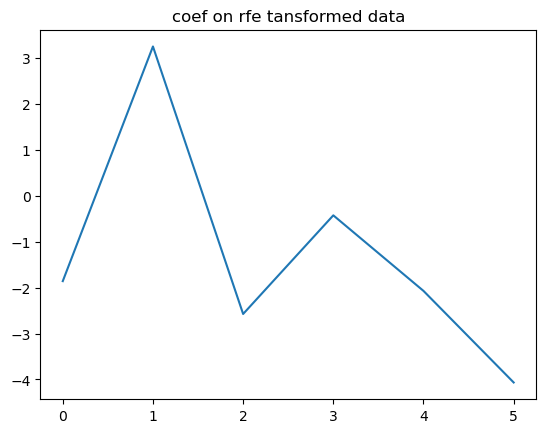

In [48]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_rfe, y_train)

print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)
print("Train Score:", lin_reg.score(X_train_rfe, y_train))
print("Test Score:", lin_reg.score(X_test_rfe, y_test))
print("MSE:", mean_squared_error(y_test,lin_reg.predict(X_test_rfe)))
plt.plot(lin_reg.coef_)
plt.title("coef on rfe tansformed data")
plt.show()

In [49]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-4, penalty=None, random_state=42) # tol means stop after loss is not getting better more than tol
sgd_reg.fit(X_train_rfe, y_train)
print("Number of iteration to convergence",sgd_reg.n_iter_)
print("Coefficients:", sgd_reg.coef_)
print("Intercept:", sgd_reg.intercept_)
print("Train Score:", sgd_reg.score(X_train_rfe, y_train))
print("Test Score:", sgd_reg.score(X_test_rfe, y_test))
print("MSE:", mean_squared_error(y_test,sgd_reg.predict(X_test_rfe)))

Number of iteration to convergence 30
Coefficients: [-1.75071865  3.28279681 -2.47976578 -0.50314267 -2.05280019 -4.08619544]
Intercept: [22.80592839]
Train Score: 0.7172323363481119
Test Score: 0.6482271292309242
MSE: 25.79683542666372


note removal of multicol features